#**NFT Project** on **Automated Attendance System** using **CNN** Model
#Assignment 2
<br>
<h4>Made under the guidance of - </h4>
<h3>Dr. Poonam Sharma </h3>
<h3>Santosh Sahu Sir </h3>
<br>

<h4>Submitted By - Group 17</h4>
<h3>Sarthak Akre (BT19CSE099) , Gourav Chayande (BT19CSE021) , Nilesh Palandurkar (BT19CSE074)</h3>



# Implementation of face recognition using neural net 

In this project an Automated Attendance Marking System is to be designed using Face detection and Recognition technology. Taking attendance in a large class is cumbersome, repetitive, and it consumes valuable class time. To avoid these problems, we are tasked with developing an automatic attendance system using deep learning framework. An automatic attendance system based on the image processing consists of two steps: face detection and face recognition.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#to make plots appear inline in the notebook
%matplotlib inline
#importing tensorflow for using gpu
import tensorflow as tf

In [2]:
#checking for gpu in system
#if not found raises an error
#or else prints the gpu 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
#we are importing important libraries such as cv,numpy,os,sklearn etc
#cv for face detection and preprocessing
import cv2
#numpy for data managing using arrays
import numpy as np
#os to input data locally
import os
#sk image for reading images into format suitable for training 
from skimage import io
#to make training and testing data from overall pool of data
from sklearn.model_selection import train_test_split
#to plot graphs
import matplotlib.pyplot as plt

In [4]:
#As we are using keras to help train our model we have to import those libraries as well
import keras
from keras.models import Sequential, load_model #sequential layers in CNN, load the computed model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation #layers, functions, utilities for each layer
#from keras.models import Sequential
from tensorflow.keras.optimizers import Adam #optimizer for the network
from keras.callbacks import TensorBoard
from keras.utils import np_utils #convert to one-hot-vector

## Listing the path of all the images

Now that each image path has been loaded we can start working on the images themselves.

To make the images readable and have the data as clean as possible we will have to do preprocessing.

But first lets have the labels for the corresponing data.

In [5]:
#make an array for all the files 
PathForDatasetArr = []
dir_path = "/content/drive/MyDrive/sem 5/NFT/googleColab/dataset2/gt_db" #change for your path of the directory of the dataset

#using the os library add all the paths of the files in the specified directory to our array
for i in os.listdir(dir_path):
    for j in os.listdir(os.path.join(dir_path, i)):
        PathForDatasetArr.append(os.path.join(dir_path,os.path.join(i, j)))

In [6]:
#here we can see that the paths of the files have been loaded into the array. For Ex - 
print(PathForDatasetArr[1])
print(len(PathForDatasetArr))

/content/drive/MyDrive/sem 5/NFT/googleColab/dataset2/gt_db/s50/05.jpg
750


## Reading each image and assigning respective labels

In [7]:
#an array for storing all the images themselves from the path 
Arr_ImageMatrices = []

#an array for storing all the corresponding labels to said images
Arr_ImageLabels = []

In [8]:
it = 0
for i in PathForDatasetArr:
    temp_ImgRead = cv2.imread(i) #read the image
    # Arr_ImageMatrices.append(cv2.cvtColor(temp_ImgRead,cv2.COLOR_BGR2RGB)
    Arr_ImageMatrices.append(cv2.cvtColor(temp_ImgRead,cv2.COLOR_BGR2RGB)) #invert the read image from BGR to RBG
    temp_LabelRead = int(os.path.split(PathForDatasetArr[it])[0].split("s")[-1]) - 1 #generate the label related to the image
    Arr_ImageLabels.append(temp_LabelRead) #append generated label
    it+=1

In [9]:
Arr_ImageMatrices[0].shape

(480, 640, 3)

###About the dataset:
We are using Georgia Tech Face Database.

<div>
<img src="https://www.researchgate.net/profile/Tarun-Gupta-23/publication/342872018/figure/fig2/AS:961257142239233@1606192970283/Sample-Images-from-Georgia-Tech-Face-Database-GTFD-16.ppm" width="600"/>
</div>


Georgia Tech face database contains images of 50 people taken in two or three sessions between 06/01/99 and 11/15/99 at the Center for Signal and Image Processing at Georgia Institute of Technology.

All people in the database are represented by 15 color JPEG images with cluttered background taken at resolution 640x480 pixels. The average size of the faces in these images is 150x150 pixels. The pictures show frontal and/or tilted faces with different facial expressions, lighting conditions and scale. Each image is manually labeled to determine the position of the face in the image. The images are stored in 50 directories s1, ..., s50. In each directory there are 15 images 01.jpg, ..., 15.jpg corresponding to one person in the database. 

Each image is manually labeled to determine the position of the face in the image.
The label files contain four integers that describe the coordinates of the face rectangles 
and a string (s1, ..., s50) indicating the identity of the face.

####Details of above:

Color Images:	Yes	
Image Size:	150x150	
Number of unique people:	50	
Number of pictures per person:	15
Different Conditions:	frontal and/or tilted faces with different facial expressions, lighting conditions and scale
Citation reference:	Ara V. Nefian and Monson H. Hayes, “Maximum likelihood training of the embedded HMM for face detection and recognition”, IEEE International Conference on Image Processing 2000.

For more information click [here.](http://www.anefian.com/research/face_reco.htm)

In [10]:
#we can see all the labels have been assigned correctly
print(PathForDatasetArr[99])#subject number 41 as seen in the path
print(Arr_ImageLabels[99])#labeled as person number 40 (array index  -> 10th subject)

/content/drive/MyDrive/sem 5/NFT/googleColab/dataset2/gt_db/s41/07.jpg
40


##Preprocessing: Face Detection using OpenCV and cropping the image to a size of 150 X 150

Now that we have our images and labels assigned correctly we need to "clean up" or pre process the images so that model is trained correctly.

For this purpose we are using openCV. OpenCV has a lot of useful features related to object detection, face detection etc.

<div>
<img src="https://miro.medium.com/max/1156/1*XX8WqHo0lyrgZfTTRQ3ESQ.jpeg" width="400"/>
</div>

We will use a face detection classifier called as Haarcascade.
Haar cascades, first introduced by Viola and Jones in their seminal 2001 publication, Rapid Object Detection using a Boosted Cascade of Simple Features, are arguably OpenCV’s most popular object detection algorithm.



Some Haar cascade benefits are that they’re very fast at computing features, they can detect faces in images regardless of the location or scale of the face and are capable of running in real-time.

<div>
<img src="https://929687.smushcdn.com/2407837/wp-content/uploads/2014/10/sliding_window_example.gif?size=323x475&lossy=1&strip=1&webp=0" height="350"/>
</div>



Something to be noted here is that we are using haarcascade front face classifier but from above details about the dataset we can see that there are "frontal and/or tilted faces with different facial expressions", so the data in this case will be noisier and may lead to lesser accuracy overall.

Also there is a lot more variation in the images in terms of ethnicity of people and even the images of people themselves as the facial features have change over the 2 year span that this was recorded.

Detecting all the tilted etc images and applying the filter to those would have been bulkier operation so we chose to work with a noisier dataset instead.

In [11]:
faceDetectClassifier = cv2.CascadeClassifier("/content/drive/MyDrive/sem 5/NFT/googleColab/dataset2/haarcascade_frontalface_default.xml")

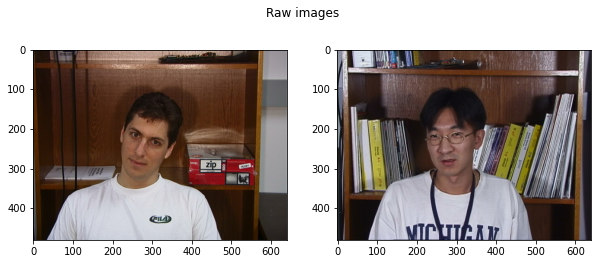

In [12]:
#here we can see the image before filtering

#change img according to var names
fig = plt.figure(figsize=(10, 4))
fig.suptitle('Raw images')

fig.add_subplot(1, 2, 1)
plt.imshow(Arr_ImageMatrices[188])

fig.add_subplot(1, 2, 2)
plt.imshow(Arr_ImageMatrices[1])
#in the images below we can see the unprocessed images at index 188 an 1 of our images array
#and haarcascade helps in face detection and thus cropping to 150x150 sized images

In [13]:
it = 0
#we will store the filtered images in a new array
Arr_ImageMatricesFin = []
for i in Arr_ImageMatrices:
    #we are just applying the filter to all the images and storing the output
    detectedFacePoints = faceDetectClassifier.detectMultiScale(i) #returns array of the face detection guesses
    if len(detectedFacePoints) == 0: #haarcascade faults
        x,y = 200,100 #most general face point
        print(str(it) + " -----error----- ")
    else:
        x,y = detectedFacePoints[0][:2] #extracting the top left point for the detected face
    #the images are not of desired shape so we crop into the detected face to change the size to 150x150
    croppedImg = i[y: y + 150, x: x + 150] #cropping 150px in x and y direction(left and down direction)
    Arr_ImageMatricesFin.append(croppedImg) #append the cropped image
    it = it + 1

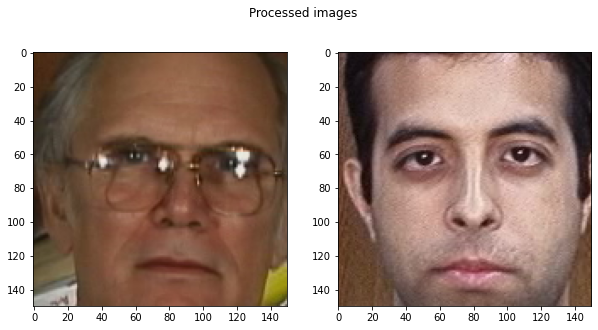

In [14]:
#here is the image after cropping
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Processed images')

fig.add_subplot(1, 2, 1)
plt.imshow(Arr_ImageMatricesFin[20])

fig.add_subplot(1, 2, 2)
plt.imshow(Arr_ImageMatricesFin[90])

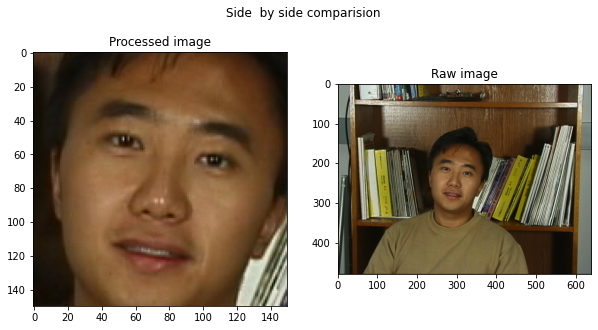

In [15]:
#a side by side comparision:
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Side  by side comparision')

fig.add_subplot(1, 2, 1)
plt.title("Processed image")
plt.imshow(Arr_ImageMatricesFin[54])

fig.add_subplot(1, 2, 2)
plt.title("Raw image")
plt.imshow(Arr_ImageMatrices[54])

#Using Convolutional Neural Network(CNN) to classify faces of subjects(students in our case - label)


## Splitting Dataset into train and test

<div>
<h2></h2>
<img src="https://d33wubrfki0l68.cloudfront.net/c39b2d19183ed14141a8b7b03943442d40efee0d/81e2a/wp-content/uploads/2019/03/train_test_split.png" width="450"/>
</div>

For making the model we need to have 2 sets on data one for training and other for testing.

The data in these also needs to be randomly selected so as to avoid overtraining.

To split the testing and training data we use sklearn model_selection and it will give us the split we want for both the labels and images without losing the overall connection between them.

In [16]:
#here our test:train is 2:8 i.e. 80% of data is for training
#again we are using the sklearn module's train-test split to split our dataset for training on CNN and for testing it's accuracy
#during the split we are converting the python lists to numpy arrays to reduce the overhead book-keeping on python lists
#so that the numpy arrays help in better performance in calculations
X_train, X_test, y_train, y_test = train_test_split(np.array(Arr_ImageMatricesFin),np.array(Arr_ImageLabels), train_size=0.8, random_state = 42)

In [17]:
#checking the dimensions after the train-test split
X_train = np.array(X_train)
X_test = np.array(X_test)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
#600 images for training and 150 images for testing

X_train shape: (600, 150, 150, 3)
X_test shape: (150, 150, 150, 3)


In [18]:
#number of classes is 50
total_classes = 50
y_train = np.array(y_train) 
y_test = np.array(y_test)
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

y_train shape: (600,)
y_test shape: (150,)



<div>
<img src="https://www.andreaperlato.com/img/onehot%20encode.png" width="600"/>
</div>

In [19]:
#np_utils.to_categorical is used to convert array of labeled data(from 0 to total_classes - 1) to one-hot vector.
Y_train = np_utils.to_categorical(y_train, total_classes)
Y_test = np_utils.to_categorical(y_test, total_classes)
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_test shape: {Y_test.shape}')
#split for each class corresponding to each vector
print(f'one hot vector - {Y_train[0]}')

Y_train shape: (600, 50)
Y_test shape: (150, 50)
one hot vector - [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [20]:
image_rows = 150 #150px height
image_cols = 150 #150px width
batch_size = 64  #train in a batch size of 64 images
im_shape=(image_rows, image_cols, 3) #Rows X Cols X 1(single channel - grayscale images)

#reshaping the matrices to that of te images
X_train = X_train.reshape(X_train.shape[0], *im_shape)
X_test = X_test.reshape(X_test.shape[0], *im_shape)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (600, 150, 150, 3)
X_test shape: (150, 150, 150, 3)


In [21]:
#normalizing data
X_train = np.array(X_train,dtype='float32')/255 #dividing by 255(pixel range)
X_test = np.array(X_test,dtype='float32')/255 #dividing by 255(pixel range)

In [22]:
#sanity check for the dimensions of the data to be fed to the model
print(f'X_Train - {X_train.shape}')
print(f'X_test - {X_test.shape}')
print(f'Y_train - {Y_train.shape}')
print(f'Y_test - {Y_test.shape}')

X_Train - (600, 150, 150, 3)
X_test - (150, 150, 150, 3)
Y_train - (600, 50)
Y_test - (150, 50)


#Making the model


<!-- ![pic to edit](https://qphs.fs.quoracdn.net/main-qimg-935f98c5a89271addd3c467b0c2f4311) -->

<img src="https://i1.wp.com/sefiks.com/wp-content/uploads/2019/04/vgg-face-architecture.jpg?w=1805&ssl=1" width="900"/>

Here we are using a specialized pre trained model called VGGFace for classification of faces.

The VGGFace refers to a series of models developed for face recognition and demonstrated on benchmark computer vision datasets by members of the Visual Geometry Group (VGG) at the University of Oxford. ([link](http://www.robots.ox.ac.uk/~vgg/))



##VGGFace model

<img src="https://i2.wp.com/sefiks.com/wp-content/uploads/2018/08/vgg-face-model.png?w=1080&ssl=1" width="1000"/>

The VGGFace model, named later, was described by Omkar Parkhi in the 2015 paper titled “Deep Face Recognition.”

A contribution of the paper was a description of how to develop a very large training dataset, required to train modern-convolutional-neural-network-based face recognition systems, to compete with the large datasets used to train models at Facebook and Google.
This dataset is then used as the basis for developing deep CNNs for face recognition tasks such as face identification and verification. Specifically, models are trained on the very large dataset, then evaluated on benchmark face recognition datasets, demonstrating that the model is effective at generating generalized features from faces.

They describe the process of training a face classifier first that uses a softmax activation function in the output layer to classify faces as people. This layer is then removed so that the output of the network is a vector feature representation of the face, called a face embedding. The model is then further trained, via fine-tuning, in order that the Euclidean distance between vectors generated for the same identity are made smaller and the vectors generated for different identities is made larger. This is achieved using a triplet loss function.

A deep convolutional neural network architecture is used in the VGG style, with blocks of convolutional layers with small kernels and ReLU activations followed by max pooling layers, and the use of fully connected layers in the classifier end of the network.

<img src="https://i1.wp.com/sefiks.com/wp-content/uploads/2018/08/layer-details-in-vgg-face.png?w=1645&ssl=1" width="900"/>

The authors of VGFFace2 provide the source code for their models, as well as pre-trained models that can be downloaded with standard deep learning frameworks

The authors of VGGFace provide the source code for their models, as well as pre-trained models that can be downloaded with standard deep learning frameworks such as Caffe and PyTorch, although there are not examples for TensorFlow or Keras.

We could convert the provided models to TensorFlow or Keras format and develop a model definition in order to load and use these pre-trained models. This work has already been done and can be used directly by third-party projects and libraries.

The library for using the VGGFace models in Keras is the keras-vggface project and library by Refik Can Malli.

Given that this is a third-party open-source project and subject to change, we have created a fork of the project here.

In [23]:
! pip install git+https://github.com/rcmalli/keras-vggface.git #clone the model at this repository
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read() #read the model file
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf
from keras_vggface.vggface import VGGFace #import the model

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-cfxkv5c3
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-cfxkv5c3


A VGGFace model can be created using the VGGFace() constructor and specifying the type of model to create via the ‘model‘ argument. 

The keras-vggface library provides three pre-trained VGGModels, a VGGFace1 model via model=’vgg16′ (the default), and two VGGFace2 models ‘resnet50‘ and ‘senet50‘.

First, we can load the VGGFace model without the classifier by setting the ‘include_top‘ argument to ‘False‘, specifying the shape of the output via the ‘input_shape‘ and setting ‘pooling‘ to ‘avg‘ so that the filter maps at the output end of the model are reduced to a vector using global average pooling.

###The summary of the model is given below as generated by keras.

In [24]:
nb_class = 50 #classes in our dataset

vgg_notop = VGGFace(include_top=False, input_shape=(150, 150, 3)) #exclude the first layer to add custom output to 50 classes
for layer in vgg_notop.layers: #set the ineer layers to non-trainable as they are already trained on face data
    layer.trainable = False

last_layer = vgg_notop.get_layer('pool5').output #last layer out of the loaded model

x = Flatten(name='flatten')(last_layer) #flatten the convolution
x = Dense(1024, activation='relu', name='fc6')(x) #add a dense layer of 1024 neurons
x = Dense(512, activation='relu', name='fc7')(x) #add a dense layer of 512 neurons
out = Dense(nb_class, activation='softmax', name='fc8')(x) #last layer with 50 neurons for 50 classes

custom_vgg_model = keras.Model(vgg_notop.input, out) #create a custom model
custom_vgg_model.summary() #print the summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 150, 150, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 150, 150, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 75, 75, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 75, 75, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 37, 37, 128)       0     

In [25]:
custom_vgg_model.compile( #compile the model created
    loss='categorical_crossentropy', #loss function used is -> categorical crossentropy
    optimizer=Adam(learning_rate=0.0001), #Adam Optimizer with a learning rate of 0.0001
    metrics=['accuracy'] #metrics to improve upon -> accuracy
)

###Training the model

In [26]:
history=custom_vgg_model.fit( #train of training set and check for test set
    np.array(X_train), np.array(Y_train), batch_size=128,
    epochs=6, verbose=2,
    validation_data=(np.array(X_test),np.array(Y_test)),
)

Epoch 1/6
5/5 - 39s - loss: 3.8578 - accuracy: 0.1400 - val_loss: 3.7352 - val_accuracy: 0.4667
Epoch 2/6
5/5 - 3s - loss: 3.5945 - accuracy: 0.7767 - val_loss: 3.5256 - val_accuracy: 0.7200
Epoch 3/6
5/5 - 3s - loss: 3.3096 - accuracy: 0.9333 - val_loss: 3.2555 - val_accuracy: 0.8133
Epoch 4/6
5/5 - 3s - loss: 2.9632 - accuracy: 0.9600 - val_loss: 2.9323 - val_accuracy: 0.8733
Epoch 5/6
5/5 - 3s - loss: 2.5677 - accuracy: 0.9733 - val_loss: 2.5707 - val_accuracy: 0.9000
Epoch 6/6
5/5 - 3s - loss: 2.1405 - accuracy: 0.9800 - val_loss: 2.1868 - val_accuracy: 0.9533


In [27]:
model_score = custom_vgg_model.evaluate( np.array(X_test),  np.array(Y_test), verbose=0) #evaluating the model performance

print(f'test loss {model_score[0]:.4f}')
print(f'test accuracy {model_score[1]:.4f}')

test loss 2.1868
test accuracy 0.9533


###After training our accuracy is nearly **95%** as seen above on test set.

In [28]:
custom_vgg_model.save("/content/drive/MyDrive/sem 5/NFT/misc/custom_vgg_model.h5") #save the model weights

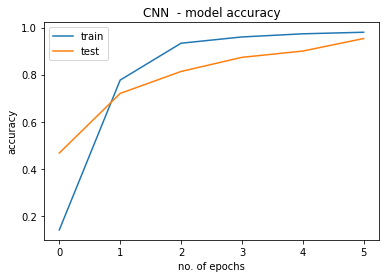

In [29]:
#plotting the accuracy vs epochs graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN  - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

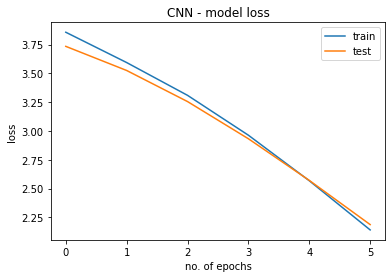

In [30]:
#plotting the loss vs epochs graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN - model loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

##Predicting classes on the test data

In [31]:
predicted_classes = custom_vgg_model.predict(X_test) #predict the classes on the test set
classes_x=np.argmax(predicted_classes,axis=1) #max output neuron --> respective class

####We will see the claases which are correctly and and incorrectly classified

In [32]:
correct_classified_indices = np.nonzero(classes_x == y_test)[0] #compare with correct labels
incorrect_classified_indices = np.nonzero(classes_x != y_test)[0] #compare with incorrect labels

In [39]:
correct_classified_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  78,  80,  82,  83,
        84,  85,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149])

In [38]:
incorrect_classified_indices

array([ 9, 24, 44, 77, 79, 81, 86])

#To integrate above into a workable attendance system using google sheets
### Here we have created a google spreadsheet with the names of the 50 students and their attendance for the day which gets automatically marked by the below snippets converting into a full-fleged model





In [35]:
!pip install gspread==4.0.0 #to mark the attendance in google sheets
!pip install gspread_formatting

In [36]:
attend = [] #class number list for atttendance
for i in range(len(classes_x)):
  if classes_x[i] == y_test[i]: #correctly classified are marked
    attend.append(classes_x[i])

p_list = []
[p_list.append(x) for x in attend if x not in p_list] #remove duplicates

for i in range(len(p_list)):
  p_list[i] += 1 #index + 1 for sheets

#printing the people who are present(their class number)
print(p_list)

[16, 29, 42, 33, 38, 3, 27, 39, 20, 41, 28, 40, 10, 31, 32, 45, 24, 18, 26, 25, 9, 13, 43, 23, 14, 21, 30, 50, 48, 15, 17, 47, 36, 37, 44, 8, 2, 4, 11, 7, 49, 34, 1, 5, 6, 12, 35, 22, 46]


In [40]:
import gspread
from gspread_formatting import *

gc = gspread.service_account(filename='/content/drive/MyDrive/Colab Notebooks/Final-Folder/credentials.json') #load credentials
sh = gc.open_by_key('1dMZPunwMGShaGjN0wUXqe4Qq0jbuE1M4EkbLRXlbHKQ') #load API key
worksheet = sh.sheet1 #name of the sheet

res = worksheet.get_all_values() #fetch all data from spreadsheet

# Present List
#p_list = [1,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,33,34,35,36,37,50] #students that are present(labels)

t_list = [False]*51 #present column

for i in p_list: #mark the attendance in array
    t_list[i]=True

fmt = cellFormat(                                                               
    backgroundColor=color(1, 1, 0),
    textFormat=textFormat(bold=False, foregroundColor=color(0, 0, 0)),
    horizontalAlignment='CENTER'
    )

for i in range (1,51):
    cell_range='A'+str(i+1)+':C'+str(i+1) #cell range to mark
    if t_list[i]:
        worksheet.update_cell(i+1,3,'Present') #mark present
    else:
        format_cell_range(worksheet, cell_range, fmt)
        worksheet.update_cell(i+1,3,'Absent') #mark absent

###Refreshing the sheet to detect any changes

In [ ]:
#spreadsheet reset code for any correction or to mark a new day's attendance

fmt_refresh = cellFormat(
    backgroundColor=color(1, 1, 1),
    textFormat=textFormat(bold=False, foregroundColor=color(0, 0, 0)),
    horizontalAlignment='CENTER'
    )

for i in range (1,51):
    cell_range='A'+str(i+1)+':C'+str(i+1)                       
    format_cell_range(worksheet, cell_range, fmt_refresh)      
   # worksheet.update_cell(i+1,3,'--')